In [1]:
import pandas as pd
import numpy as np
from glob import glob

# Load CSVs
files = glob('scan_data/*.csv')
df_list = []
for file in files:
    df = pd.read_csv(file, skiprows=5, na_values=['', 'NaN', -99.9])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed', na=False)]
    df.columns = [' '.join(col.split()) for col in df.columns.str.strip()]
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M', errors='coerce')
    df = df.dropna(subset=['datetime'])
    df = df.set_index('datetime').drop(['Date', 'Time'], axis=1, errors='ignore')
    df_list.append(df)

# Concatenate and sort
df = pd.concat(df_list).sort_index()

# Normalize column names
df.columns = [' '.join(col.split()) for col in df.columns.str.strip()]

# Replace -99.9 with NaN
df = df.replace(-99.9, np.nan)

# Check NaN proportions
nan_proportions = df.isna().mean()
print("NaN proportions:\n", nan_proportions)

# Drop columns with >30% NaNs
valid_cols = nan_proportions[nan_proportions < 0.3].index
df = df[valid_cols]
print("Kept columns:", valid_cols)

# Use PRCP.H-1 (in) as primary precipitation
if 'PRCP.H-1 (in)' in df.columns:
    df['Precip (in)'] = df['PRCP.H-1 (in)'].fillna(0)
    df = df.drop('PRCP.H-1 (in)', axis=1, errors='ignore')
elif 'PREC.I-1 (in)' in df.columns:
    df['Precip (in)'] = df['PREC.I-1 (in)'].fillna(0)
    df = df.drop('PREC.I-1 (in)', axis=1, errors='ignore')
else:
    print("Warning: No precipitation column found. Adding zero-filled column.")
    df['Precip (in)'] = 0

# Subset to start at 1997-03-16
target_col = 'SMS.I-1:-4 (pct) (loam)'
if target_col not in df.columns:
    possible_targets = [col for col in df.columns if 'SMS.I-1:-8' in col]
    if possible_targets:
        target_col = possible_targets[0]
        print(f"Adjusted target_col to: {target_col}")
    else:
        raise KeyError("No SMS.I-1:-8 column found in DataFrame.")

first_valid = df[target_col].first_valid_index()
print("First non-NaN SMS.I-1:-8:", first_valid)
df = df.loc[first_valid:]  # ~245k rows

# Interpolate remaining NaNs
df = df.interpolate(method='time', limit_direction='both')

# Ensure hourly continuity
df = df.resample('h').interpolate(method='time')

# Save
df.to_csv('processed_hourly_scan_1997_2025.csv')
print("First 5 rows:\n", df.head())
print("Columns:", df.columns)

NaN proportions:
 Site Id                     0.000000
PREC.I-1 (in)               0.854160
TOBS.I-1 (degC)             0.000612
STO.I-1:-2 (degC)           0.007993
STO.I-1:-4 (degC)           0.108889
STO.I-1:-8 (degC)           0.003780
STO.I-1:-20 (degC)          0.004372
STO.I-1:-40 (degC)          0.148136
STO.I-1:-80 (degC)          0.999796
BATT.I-1 (volt)             0.000387
STV.H-1:-4 (degC)           0.999918
SRAD.I-1 (watt)             0.993936
ETIL.I-1 (volt)             0.776799
ETIB.I-1 (volt)             0.776811
TMAX.H-1 (degC)             0.009738
TMIN.H-1 (degC)             0.009906
TAVG.H-1 (degC)             0.009865
SMS.I-1:-2 (pct) (loam)     0.028979
SMS.I-1:-4 (pct) (loam)     0.063263
SMS.I-1:-8 (pct) (loam)     0.030904
SMS.I-1:-20 (pct) (loam)    0.112363
SMS.I-1:-40 (pct) (loam)    0.202664
SAL.I-1:-2 (gram)           0.017034
SAL.I-1:-4 (gram)           0.030916
SAL.I-1:-8 (gram)           0.012821
SAL.I-1:-20 (gram)          0.016161
SAL.I-1:-40 (gram)  

In [2]:
import warnings
warnings.filterwarnings('ignore')

# User-defined split date (change this to your desired date)
split_date = pd.Timestamp('2020-01-01')  # Train up to this date, test after

# Define horizons for hourly predictions (1 to 168 hours)
horizons = list(range(1, 169))  # 168 horizons

# Add cyclic date features
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

# Target and features, including target_col for lagging
key_features = [
    'Precip (in)',
    'TOBS.I-1 (degC)',
    'TAVG.H-1 (degC)',
    'RHUM.I-1 (pct)',
    'SMS.I-1:-4 (pct) (loam)',  # target_col
    'month_sin',
    'month_cos',
    'dayofyear_sin',
    'dayofyear_cos',
    'hour_sin',
    'hour_cos',
]
feature_cols = [col for col in df.columns if col in key_features]  # Include all key features

# Lagged features (168 hours for 7 days)
lags = 168
lagged_cols = []
for col in feature_cols:
    for lag in range(1, lags + 1):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
        lagged_cols.append(f'{col}_lag{lag}')

## Add lagged hour features for diurnal effect
#for lag in range(1, 24):  # Lag up to 23 hours
#    df[f'hour_sin_lag{lag}'] = df['hour_sin'].shift(lag)
#    df[f'hour_cos_lag{lag}'] = df['hour_cos'].shift(lag)
#    lagged_cols.extend([f'hour_sin_lag{lag}', f'hour_cos_lag{lag}'])

# Defragment DataFrame
df = df.copy()

# Rolling and cyclic features
df['Precip_24h_sum'] = df['Precip (in)'].rolling(24).sum()
df['TOBS_6h_mean'] = df['TOBS.I-1 (degC)'].rolling(6).mean()

# Drop NaNs from lagging
df = df.dropna()

# Select top 50 features, ensuring hour features are considered
X_cols = lagged_cols + ['Precip_24h_sum', 'TOBS_6h_mean', 'hour_sin', 'hour_cos']
if len(X_cols) > 50:
    corr = df[X_cols].corrwith(df[target_col]).abs()
    X_cols = corr.nlargest(50).index.tolist()
    X_cols = list(set(X_cols + ['hour_sin', 'hour_cos']))  # Force inclusion if not in top 200
    if len(X_cols) > 50:
        X_cols = X_cols[:50]  # Trim if exceeds 50

# Split into train and test based on user-defined date
train_df = df[df.index < split_date]
test_df = df[df.index >= split_date]

# Prepare X/y for train
X_train_list, y_train_list = [], []
for h in horizons:
    X = train_df[X_cols]
    y = train_df[target_col].shift(-h)
    valid_idx = y.notna()
    X_train_list.append(X[valid_idx])
    y_train_list.append(y[valid_idx])

# Prepare X/y for test (for accuracy comparison)
X_test_list, y_test_list = [], []
for h in horizons:
    X = test_df[X_cols]
    y = test_df[target_col].shift(-h)
    valid_idx = y.notna()
    X_test_list.append(X[valid_idx])
    y_test_list.append(y[valid_idx])

In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from tqdm import tqdm
import math

models = []
for i, h in tqdm(enumerate(horizons), total=len(horizons), desc="Training models"):
    model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_list[i], y_train_list[i])
    models.append(model)
    
    # Predict on test set
    test_preds = model.predict(X_test_list[i])
    mae = mean_absolute_error(y_test_list[i], test_preds)
    rmse = math.sqrt(mean_squared_error(y_test_list[i], test_preds))
    print(f'Horizon +{h}h - Test MAE: {mae:.2f}%, RMSE: {rmse:.2f}%')
    
    joblib.dump(model, f'model_horizon_{h}h.pkl')

Training models:   1%|▍                                                                | 1/168 [00:01<04:52,  1.75s/it]

Horizon +1h - Test MAE: 0.77%, RMSE: 1.83%


Training models:   1%|▊                                                                | 2/168 [00:02<03:25,  1.24s/it]

Horizon +2h - Test MAE: 0.81%, RMSE: 1.86%


Training models:   2%|█▏                                                               | 3/168 [00:03<02:39,  1.04it/s]

Horizon +3h - Test MAE: 0.84%, RMSE: 1.89%


Training models:   2%|█▌                                                               | 4/168 [00:03<02:16,  1.20it/s]

Horizon +4h - Test MAE: 0.91%, RMSE: 1.97%


Training models:   3%|█▉                                                               | 5/168 [00:04<02:03,  1.32it/s]

Horizon +5h - Test MAE: 0.94%, RMSE: 2.02%


Training models:   4%|██▎                                                              | 6/168 [00:05<01:55,  1.40it/s]

Horizon +6h - Test MAE: 0.98%, RMSE: 2.07%


Training models:   4%|██▋                                                              | 7/168 [00:05<01:51,  1.45it/s]

Horizon +7h - Test MAE: 0.99%, RMSE: 2.08%


Training models:   5%|███                                                              | 8/168 [00:06<01:49,  1.47it/s]

Horizon +8h - Test MAE: 1.03%, RMSE: 2.12%


Training models:   5%|███▍                                                             | 9/168 [00:07<01:46,  1.49it/s]

Horizon +9h - Test MAE: 1.05%, RMSE: 2.16%


Training models:   6%|███▊                                                            | 10/168 [00:07<01:44,  1.51it/s]

Horizon +10h - Test MAE: 1.07%, RMSE: 2.18%


Training models:   7%|████▏                                                           | 11/168 [00:08<01:42,  1.53it/s]

Horizon +11h - Test MAE: 1.10%, RMSE: 2.24%


Training models:   7%|████▌                                                           | 12/168 [00:09<01:41,  1.53it/s]

Horizon +12h - Test MAE: 1.11%, RMSE: 2.23%


Training models:   8%|████▉                                                           | 13/168 [00:09<01:41,  1.53it/s]

Horizon +13h - Test MAE: 1.14%, RMSE: 2.27%


Training models:   8%|█████▎                                                          | 14/168 [00:10<01:43,  1.49it/s]

Horizon +14h - Test MAE: 1.18%, RMSE: 2.29%


Training models:   9%|█████▋                                                          | 15/168 [00:11<01:41,  1.51it/s]

Horizon +15h - Test MAE: 1.19%, RMSE: 2.34%


Training models:  10%|██████                                                          | 16/168 [00:11<01:39,  1.53it/s]

Horizon +16h - Test MAE: 1.23%, RMSE: 2.36%


Training models:  10%|██████▍                                                         | 17/168 [00:12<01:37,  1.55it/s]

Horizon +17h - Test MAE: 1.22%, RMSE: 2.34%


Training models:  11%|██████▊                                                         | 18/168 [00:12<01:37,  1.53it/s]

Horizon +18h - Test MAE: 1.24%, RMSE: 2.37%


Training models:  11%|███████▏                                                        | 19/168 [00:13<01:36,  1.54it/s]

Horizon +19h - Test MAE: 1.28%, RMSE: 2.45%


Training models:  12%|███████▌                                                        | 20/168 [00:14<01:34,  1.57it/s]

Horizon +20h - Test MAE: 1.28%, RMSE: 2.46%


Training models:  12%|████████                                                        | 21/168 [00:14<01:33,  1.57it/s]

Horizon +21h - Test MAE: 1.32%, RMSE: 2.49%


Training models:  13%|████████▍                                                       | 22/168 [00:15<01:31,  1.59it/s]

Horizon +22h - Test MAE: 1.36%, RMSE: 2.54%


Training models:  14%|████████▊                                                       | 23/168 [00:16<01:31,  1.58it/s]

Horizon +23h - Test MAE: 1.36%, RMSE: 2.54%


Training models:  14%|█████████▏                                                      | 24/168 [00:16<01:32,  1.56it/s]

Horizon +24h - Test MAE: 1.41%, RMSE: 2.61%


Training models:  15%|█████████▌                                                      | 25/168 [00:17<01:32,  1.55it/s]

Horizon +25h - Test MAE: 1.44%, RMSE: 2.63%


Training models:  15%|█████████▉                                                      | 26/168 [00:18<01:31,  1.55it/s]

Horizon +26h - Test MAE: 1.47%, RMSE: 2.66%


Training models:  16%|██████████▎                                                     | 27/168 [00:18<01:33,  1.51it/s]

Horizon +27h - Test MAE: 1.50%, RMSE: 2.68%


Training models:  17%|██████████▋                                                     | 28/168 [00:19<01:31,  1.54it/s]

Horizon +28h - Test MAE: 1.51%, RMSE: 2.70%


Training models:  17%|███████████                                                     | 29/168 [00:20<01:32,  1.51it/s]

Horizon +29h - Test MAE: 1.54%, RMSE: 2.73%


Training models:  18%|███████████▍                                                    | 30/168 [00:20<01:36,  1.43it/s]

Horizon +30h - Test MAE: 1.55%, RMSE: 2.73%


Training models:  18%|███████████▊                                                    | 31/168 [00:21<01:33,  1.46it/s]

Horizon +31h - Test MAE: 1.57%, RMSE: 2.76%


Training models:  19%|████████████▏                                                   | 32/168 [00:22<01:31,  1.49it/s]

Horizon +32h - Test MAE: 1.60%, RMSE: 2.76%


Training models:  20%|████████████▌                                                   | 33/168 [00:22<01:29,  1.50it/s]

Horizon +33h - Test MAE: 1.61%, RMSE: 2.79%


Training models:  20%|████████████▉                                                   | 34/168 [00:23<01:28,  1.52it/s]

Horizon +34h - Test MAE: 1.61%, RMSE: 2.79%


Training models:  21%|█████████████▎                                                  | 35/168 [00:24<01:27,  1.52it/s]

Horizon +35h - Test MAE: 1.66%, RMSE: 2.82%


Training models:  21%|█████████████▋                                                  | 36/168 [00:24<01:26,  1.52it/s]

Horizon +36h - Test MAE: 1.66%, RMSE: 2.82%


Training models:  22%|██████████████                                                  | 37/168 [00:25<01:26,  1.51it/s]

Horizon +37h - Test MAE: 1.70%, RMSE: 2.87%


Training models:  23%|██████████████▍                                                 | 38/168 [00:26<01:25,  1.52it/s]

Horizon +38h - Test MAE: 1.71%, RMSE: 2.88%


Training models:  23%|██████████████▊                                                 | 39/168 [00:26<01:24,  1.53it/s]

Horizon +39h - Test MAE: 1.71%, RMSE: 2.88%


Training models:  24%|███████████████▏                                                | 40/168 [00:27<01:23,  1.53it/s]

Horizon +40h - Test MAE: 1.72%, RMSE: 2.90%


Training models:  24%|███████████████▌                                                | 41/168 [00:28<01:28,  1.44it/s]

Horizon +41h - Test MAE: 1.73%, RMSE: 2.91%


Training models:  25%|████████████████                                                | 42/168 [00:28<01:27,  1.44it/s]

Horizon +42h - Test MAE: 1.79%, RMSE: 2.96%


Training models:  26%|████████████████▍                                               | 43/168 [00:29<01:25,  1.47it/s]

Horizon +43h - Test MAE: 1.76%, RMSE: 2.93%


Training models:  26%|████████████████▊                                               | 44/168 [00:30<01:23,  1.49it/s]

Horizon +44h - Test MAE: 1.75%, RMSE: 2.95%


Training models:  27%|█████████████████▏                                              | 45/168 [00:30<01:21,  1.51it/s]

Horizon +45h - Test MAE: 1.75%, RMSE: 2.93%


Training models:  27%|█████████████████▌                                              | 46/168 [00:31<01:23,  1.47it/s]

Horizon +46h - Test MAE: 1.83%, RMSE: 3.00%


Training models:  28%|█████████████████▉                                              | 47/168 [00:32<01:22,  1.47it/s]

Horizon +47h - Test MAE: 1.83%, RMSE: 3.01%


Training models:  29%|██████████████████▎                                             | 48/168 [00:32<01:25,  1.40it/s]

Horizon +48h - Test MAE: 1.83%, RMSE: 3.02%


Training models:  29%|██████████████████▋                                             | 49/168 [00:33<01:26,  1.37it/s]

Horizon +49h - Test MAE: 1.89%, RMSE: 3.07%


Training models:  30%|███████████████████                                             | 50/168 [00:34<01:26,  1.36it/s]

Horizon +50h - Test MAE: 1.87%, RMSE: 3.04%


Training models:  30%|███████████████████▍                                            | 51/168 [00:35<01:23,  1.39it/s]

Horizon +51h - Test MAE: 1.94%, RMSE: 3.11%


Training models:  31%|███████████████████▊                                            | 52/168 [00:35<01:24,  1.38it/s]

Horizon +52h - Test MAE: 1.95%, RMSE: 3.13%


Training models:  32%|████████████████████▏                                           | 53/168 [00:36<01:21,  1.41it/s]

Horizon +53h - Test MAE: 1.96%, RMSE: 3.12%


Training models:  32%|████████████████████▌                                           | 54/168 [00:37<01:19,  1.44it/s]

Horizon +54h - Test MAE: 2.00%, RMSE: 3.19%


Training models:  33%|████████████████████▉                                           | 55/168 [00:37<01:17,  1.46it/s]

Horizon +55h - Test MAE: 2.01%, RMSE: 3.19%


Training models:  33%|█████████████████████▎                                          | 56/168 [00:38<01:15,  1.49it/s]

Horizon +56h - Test MAE: 2.02%, RMSE: 3.19%


Training models:  34%|█████████████████████▋                                          | 57/168 [00:39<01:22,  1.35it/s]

Horizon +57h - Test MAE: 2.04%, RMSE: 3.20%


Training models:  35%|██████████████████████                                          | 58/168 [00:40<01:24,  1.30it/s]

Horizon +58h - Test MAE: 2.08%, RMSE: 3.26%


Training models:  35%|██████████████████████▍                                         | 59/168 [00:41<01:22,  1.32it/s]

Horizon +59h - Test MAE: 2.08%, RMSE: 3.26%


Training models:  36%|██████████████████████▊                                         | 60/168 [00:41<01:23,  1.29it/s]

Horizon +60h - Test MAE: 2.09%, RMSE: 3.27%


Training models:  36%|███████████████████████▏                                        | 61/168 [00:42<01:22,  1.29it/s]

Horizon +61h - Test MAE: 2.09%, RMSE: 3.27%


Training models:  37%|███████████████████████▌                                        | 62/168 [00:43<01:24,  1.25it/s]

Horizon +62h - Test MAE: 2.11%, RMSE: 3.29%


Training models:  38%|████████████████████████                                        | 63/168 [00:44<01:22,  1.28it/s]

Horizon +63h - Test MAE: 2.14%, RMSE: 3.31%


Training models:  38%|████████████████████████▍                                       | 64/168 [00:44<01:19,  1.31it/s]

Horizon +64h - Test MAE: 2.15%, RMSE: 3.33%


Training models:  39%|████████████████████████▊                                       | 65/168 [00:45<01:21,  1.26it/s]

Horizon +65h - Test MAE: 2.16%, RMSE: 3.34%


Training models:  39%|█████████████████████████▏                                      | 66/168 [00:46<01:22,  1.23it/s]

Horizon +66h - Test MAE: 2.17%, RMSE: 3.36%


Training models:  40%|█████████████████████████▌                                      | 67/168 [00:47<01:21,  1.24it/s]

Horizon +67h - Test MAE: 2.17%, RMSE: 3.36%


Training models:  40%|█████████████████████████▉                                      | 68/168 [00:48<01:19,  1.25it/s]

Horizon +68h - Test MAE: 2.19%, RMSE: 3.39%


Training models:  41%|██████████████████████████▎                                     | 69/168 [00:48<01:17,  1.28it/s]

Horizon +69h - Test MAE: 2.21%, RMSE: 3.40%


Training models:  42%|██████████████████████████▋                                     | 70/168 [00:49<01:15,  1.30it/s]

Horizon +70h - Test MAE: 2.18%, RMSE: 3.37%


Training models:  42%|███████████████████████████                                     | 71/168 [00:50<01:11,  1.36it/s]

Horizon +71h - Test MAE: 2.22%, RMSE: 3.42%


Training models:  43%|███████████████████████████▍                                    | 72/168 [00:51<01:09,  1.39it/s]

Horizon +72h - Test MAE: 2.26%, RMSE: 3.46%


Training models:  43%|███████████████████████████▊                                    | 73/168 [00:51<01:08,  1.39it/s]

Horizon +73h - Test MAE: 2.26%, RMSE: 3.44%


Training models:  44%|████████████████████████████▏                                   | 74/168 [00:52<01:07,  1.39it/s]

Horizon +74h - Test MAE: 2.28%, RMSE: 3.48%


Training models:  45%|████████████████████████████▌                                   | 75/168 [00:53<01:06,  1.41it/s]

Horizon +75h - Test MAE: 2.30%, RMSE: 3.52%


Training models:  45%|████████████████████████████▉                                   | 76/168 [00:53<01:05,  1.40it/s]

Horizon +76h - Test MAE: 2.32%, RMSE: 3.54%


Training models:  46%|█████████████████████████████▎                                  | 77/168 [00:54<01:03,  1.43it/s]

Horizon +77h - Test MAE: 2.34%, RMSE: 3.55%


Training models:  46%|█████████████████████████████▋                                  | 78/168 [00:55<01:02,  1.45it/s]

Horizon +78h - Test MAE: 2.37%, RMSE: 3.57%


Training models:  47%|██████████████████████████████                                  | 79/168 [00:55<01:01,  1.44it/s]

Horizon +79h - Test MAE: 2.40%, RMSE: 3.63%


Training models:  48%|██████████████████████████████▍                                 | 80/168 [00:56<01:02,  1.40it/s]

Horizon +80h - Test MAE: 2.41%, RMSE: 3.62%


Training models:  48%|██████████████████████████████▊                                 | 81/168 [00:57<01:01,  1.42it/s]

Horizon +81h - Test MAE: 2.39%, RMSE: 3.59%


Training models:  49%|███████████████████████████████▏                                | 82/168 [00:58<00:59,  1.45it/s]

Horizon +82h - Test MAE: 2.42%, RMSE: 3.61%


Training models:  49%|███████████████████████████████▌                                | 83/168 [00:58<00:59,  1.42it/s]

Horizon +83h - Test MAE: 2.42%, RMSE: 3.62%


Training models:  50%|████████████████████████████████                                | 84/168 [00:59<00:58,  1.45it/s]

Horizon +84h - Test MAE: 2.45%, RMSE: 3.63%


Training models:  51%|████████████████████████████████▍                               | 85/168 [01:00<00:57,  1.45it/s]

Horizon +85h - Test MAE: 2.45%, RMSE: 3.64%


Training models:  51%|████████████████████████████████▊                               | 86/168 [01:00<00:55,  1.48it/s]

Horizon +86h - Test MAE: 2.46%, RMSE: 3.63%


Training models:  52%|█████████████████████████████████▏                              | 87/168 [01:01<00:55,  1.46it/s]

Horizon +87h - Test MAE: 2.48%, RMSE: 3.67%


Training models:  52%|█████████████████████████████████▌                              | 88/168 [01:02<00:56,  1.43it/s]

Horizon +88h - Test MAE: 2.49%, RMSE: 3.66%


Training models:  53%|█████████████████████████████████▉                              | 89/168 [01:03<00:58,  1.36it/s]

Horizon +89h - Test MAE: 2.50%, RMSE: 3.67%


Training models:  54%|██████████████████████████████████▎                             | 90/168 [01:03<00:58,  1.33it/s]

Horizon +90h - Test MAE: 2.49%, RMSE: 3.68%


Training models:  54%|██████████████████████████████████▋                             | 91/168 [01:04<00:59,  1.29it/s]

Horizon +91h - Test MAE: 2.51%, RMSE: 3.71%


Training models:  55%|███████████████████████████████████                             | 92/168 [01:05<00:59,  1.29it/s]

Horizon +92h - Test MAE: 2.52%, RMSE: 3.71%


Training models:  55%|███████████████████████████████████▍                            | 93/168 [01:06<00:59,  1.27it/s]

Horizon +93h - Test MAE: 2.55%, RMSE: 3.75%


Training models:  56%|███████████████████████████████████▊                            | 94/168 [01:06<00:56,  1.31it/s]

Horizon +94h - Test MAE: 2.55%, RMSE: 3.75%


Training models:  57%|████████████████████████████████████▏                           | 95/168 [01:07<00:55,  1.32it/s]

Horizon +95h - Test MAE: 2.56%, RMSE: 3.77%


Training models:  57%|████████████████████████████████████▌                           | 96/168 [01:08<00:55,  1.30it/s]

Horizon +96h - Test MAE: 2.60%, RMSE: 3.81%


Training models:  58%|████████████████████████████████████▉                           | 97/168 [01:09<00:55,  1.29it/s]

Horizon +97h - Test MAE: 2.60%, RMSE: 3.79%


Training models:  58%|█████████████████████████████████████▎                          | 98/168 [01:09<00:51,  1.35it/s]

Horizon +98h - Test MAE: 2.61%, RMSE: 3.81%


Training models:  59%|█████████████████████████████████████▋                          | 99/168 [01:10<00:49,  1.40it/s]

Horizon +99h - Test MAE: 2.60%, RMSE: 3.78%


Training models:  60%|█████████████████████████████████████▌                         | 100/168 [01:11<00:48,  1.41it/s]

Horizon +100h - Test MAE: 2.65%, RMSE: 3.85%


Training models:  60%|█████████████████████████████████████▉                         | 101/168 [01:11<00:46,  1.45it/s]

Horizon +101h - Test MAE: 2.66%, RMSE: 3.86%


Training models:  61%|██████████████████████████████████████▎                        | 102/168 [01:12<00:45,  1.44it/s]

Horizon +102h - Test MAE: 2.67%, RMSE: 3.87%


Training models:  61%|██████████████████████████████████████▋                        | 103/168 [01:13<00:44,  1.45it/s]

Horizon +103h - Test MAE: 2.66%, RMSE: 3.86%


Training models:  62%|███████████████████████████████████████                        | 104/168 [01:14<00:44,  1.44it/s]

Horizon +104h - Test MAE: 2.68%, RMSE: 3.89%


Training models:  62%|███████████████████████████████████████▍                       | 105/168 [01:14<00:43,  1.45it/s]

Horizon +105h - Test MAE: 2.70%, RMSE: 3.90%


Training models:  63%|███████████████████████████████████████▊                       | 106/168 [01:15<00:42,  1.47it/s]

Horizon +106h - Test MAE: 2.71%, RMSE: 3.91%


Training models:  64%|████████████████████████████████████████▏                      | 107/168 [01:16<00:41,  1.46it/s]

Horizon +107h - Test MAE: 2.72%, RMSE: 3.94%


Training models:  64%|████████████████████████████████████████▌                      | 108/168 [01:16<00:40,  1.49it/s]

Horizon +108h - Test MAE: 2.74%, RMSE: 3.94%


Training models:  65%|████████████████████████████████████████▉                      | 109/168 [01:17<00:39,  1.49it/s]

Horizon +109h - Test MAE: 2.73%, RMSE: 3.94%


Training models:  65%|█████████████████████████████████████████▎                     | 110/168 [01:18<00:38,  1.49it/s]

Horizon +110h - Test MAE: 2.77%, RMSE: 3.96%


Training models:  66%|█████████████████████████████████████████▋                     | 111/168 [01:18<00:37,  1.50it/s]

Horizon +111h - Test MAE: 2.76%, RMSE: 3.95%


Training models:  67%|██████████████████████████████████████████                     | 112/168 [01:19<00:38,  1.46it/s]

Horizon +112h - Test MAE: 2.75%, RMSE: 3.96%


Training models:  67%|██████████████████████████████████████████▍                    | 113/168 [01:20<00:37,  1.47it/s]

Horizon +113h - Test MAE: 2.76%, RMSE: 3.95%


Training models:  68%|██████████████████████████████████████████▊                    | 114/168 [01:20<00:36,  1.48it/s]

Horizon +114h - Test MAE: 2.80%, RMSE: 4.00%


Training models:  68%|███████████████████████████████████████████▏                   | 115/168 [01:21<00:35,  1.49it/s]

Horizon +115h - Test MAE: 2.82%, RMSE: 4.03%


Training models:  69%|███████████████████████████████████████████▌                   | 116/168 [01:22<00:34,  1.49it/s]

Horizon +116h - Test MAE: 2.80%, RMSE: 4.01%


Training models:  70%|███████████████████████████████████████████▉                   | 117/168 [01:22<00:33,  1.50it/s]

Horizon +117h - Test MAE: 2.80%, RMSE: 4.00%


Training models:  70%|████████████████████████████████████████████▎                  | 118/168 [01:23<00:34,  1.46it/s]

Horizon +118h - Test MAE: 2.84%, RMSE: 4.05%


Training models:  71%|████████████████████████████████████████████▋                  | 119/168 [01:24<00:33,  1.46it/s]

Horizon +119h - Test MAE: 2.83%, RMSE: 4.09%


Training models:  71%|█████████████████████████████████████████████                  | 120/168 [01:24<00:33,  1.42it/s]

Horizon +120h - Test MAE: 2.85%, RMSE: 4.09%


Training models:  72%|█████████████████████████████████████████████▍                 | 121/168 [01:25<00:32,  1.43it/s]

Horizon +121h - Test MAE: 2.85%, RMSE: 4.10%


Training models:  73%|█████████████████████████████████████████████▊                 | 122/168 [01:26<00:31,  1.45it/s]

Horizon +122h - Test MAE: 2.90%, RMSE: 4.11%


Training models:  73%|██████████████████████████████████████████████▏                | 123/168 [01:26<00:31,  1.45it/s]

Horizon +123h - Test MAE: 2.89%, RMSE: 4.12%


Training models:  74%|██████████████████████████████████████████████▌                | 124/168 [01:27<00:30,  1.46it/s]

Horizon +124h - Test MAE: 2.91%, RMSE: 4.16%


Training models:  74%|██████████████████████████████████████████████▉                | 125/168 [01:28<00:29,  1.46it/s]

Horizon +125h - Test MAE: 2.90%, RMSE: 4.14%


Training models:  75%|███████████████████████████████████████████████▎               | 126/168 [01:28<00:28,  1.47it/s]

Horizon +126h - Test MAE: 2.91%, RMSE: 4.14%


Training models:  76%|███████████████████████████████████████████████▋               | 127/168 [01:29<00:28,  1.44it/s]

Horizon +127h - Test MAE: 2.92%, RMSE: 4.13%


Training models:  76%|████████████████████████████████████████████████               | 128/168 [01:30<00:28,  1.41it/s]

Horizon +128h - Test MAE: 2.93%, RMSE: 4.17%


Training models:  77%|████████████████████████████████████████████████▍              | 129/168 [01:31<00:27,  1.41it/s]

Horizon +129h - Test MAE: 2.94%, RMSE: 4.19%


Training models:  77%|████████████████████████████████████████████████▊              | 130/168 [01:31<00:27,  1.40it/s]

Horizon +130h - Test MAE: 2.97%, RMSE: 4.22%


Training models:  78%|█████████████████████████████████████████████████▏             | 131/168 [01:32<00:26,  1.41it/s]

Horizon +131h - Test MAE: 2.97%, RMSE: 4.21%


Training models:  79%|█████████████████████████████████████████████████▌             | 132/168 [01:33<00:25,  1.41it/s]

Horizon +132h - Test MAE: 2.99%, RMSE: 4.25%


Training models:  79%|█████████████████████████████████████████████████▉             | 133/168 [01:34<00:25,  1.40it/s]

Horizon +133h - Test MAE: 3.00%, RMSE: 4.27%


Training models:  80%|██████████████████████████████████████████████████▎            | 134/168 [01:34<00:23,  1.42it/s]

Horizon +134h - Test MAE: 3.00%, RMSE: 4.27%


Training models:  80%|██████████████████████████████████████████████████▋            | 135/168 [01:35<00:23,  1.42it/s]

Horizon +135h - Test MAE: 3.00%, RMSE: 4.28%


Training models:  81%|███████████████████████████████████████████████████            | 136/168 [01:36<00:23,  1.38it/s]

Horizon +136h - Test MAE: 3.02%, RMSE: 4.32%


Training models:  82%|███████████████████████████████████████████████████▍           | 137/168 [01:36<00:22,  1.36it/s]

Horizon +137h - Test MAE: 3.00%, RMSE: 4.29%


Training models:  82%|███████████████████████████████████████████████████▊           | 138/168 [01:37<00:22,  1.36it/s]

Horizon +138h - Test MAE: 3.05%, RMSE: 4.35%


Training models:  83%|████████████████████████████████████████████████████▏          | 139/168 [01:38<00:21,  1.35it/s]

Horizon +139h - Test MAE: 3.03%, RMSE: 4.34%


Training models:  83%|████████████████████████████████████████████████████▌          | 140/168 [01:39<00:20,  1.37it/s]

Horizon +140h - Test MAE: 3.03%, RMSE: 4.34%


Training models:  84%|████████████████████████████████████████████████████▉          | 141/168 [01:39<00:19,  1.41it/s]

Horizon +141h - Test MAE: 3.08%, RMSE: 4.39%


Training models:  85%|█████████████████████████████████████████████████████▎         | 142/168 [01:40<00:18,  1.43it/s]

Horizon +142h - Test MAE: 3.06%, RMSE: 4.40%


Training models:  85%|█████████████████████████████████████████████████████▋         | 143/168 [01:41<00:17,  1.43it/s]

Horizon +143h - Test MAE: 3.08%, RMSE: 4.44%


Training models:  86%|██████████████████████████████████████████████████████         | 144/168 [01:41<00:17,  1.38it/s]

Horizon +144h - Test MAE: 3.14%, RMSE: 4.45%


Training models:  86%|██████████████████████████████████████████████████████▍        | 145/168 [01:42<00:16,  1.40it/s]

Horizon +145h - Test MAE: 3.13%, RMSE: 4.46%


Training models:  87%|██████████████████████████████████████████████████████▊        | 146/168 [01:43<00:15,  1.39it/s]

Horizon +146h - Test MAE: 3.12%, RMSE: 4.45%


Training models:  88%|███████████████████████████████████████████████████████▏       | 147/168 [01:44<00:16,  1.31it/s]

Horizon +147h - Test MAE: 3.13%, RMSE: 4.45%


Training models:  88%|███████████████████████████████████████████████████████▌       | 148/168 [01:44<00:15,  1.31it/s]

Horizon +148h - Test MAE: 3.13%, RMSE: 4.48%


Training models:  89%|███████████████████████████████████████████████████████▉       | 149/168 [01:45<00:14,  1.34it/s]

Horizon +149h - Test MAE: 3.16%, RMSE: 4.48%


Training models:  89%|████████████████████████████████████████████████████████▎      | 150/168 [01:46<00:13,  1.37it/s]

Horizon +150h - Test MAE: 3.17%, RMSE: 4.52%


Training models:  90%|████████████████████████████████████████████████████████▋      | 151/168 [01:47<00:12,  1.38it/s]

Horizon +151h - Test MAE: 3.17%, RMSE: 4.49%


Training models:  90%|█████████████████████████████████████████████████████████      | 152/168 [01:47<00:11,  1.34it/s]

Horizon +152h - Test MAE: 3.19%, RMSE: 4.53%


Training models:  91%|█████████████████████████████████████████████████████████▍     | 153/168 [01:48<00:11,  1.35it/s]

Horizon +153h - Test MAE: 3.22%, RMSE: 4.56%


Training models:  92%|█████████████████████████████████████████████████████████▊     | 154/168 [01:49<00:10,  1.36it/s]

Horizon +154h - Test MAE: 3.22%, RMSE: 4.58%


Training models:  92%|██████████████████████████████████████████████████████████▏    | 155/168 [01:50<00:10,  1.27it/s]

Horizon +155h - Test MAE: 3.24%, RMSE: 4.55%


Training models:  93%|██████████████████████████████████████████████████████████▌    | 156/168 [01:51<00:09,  1.29it/s]

Horizon +156h - Test MAE: 3.26%, RMSE: 4.63%


Training models:  93%|██████████████████████████████████████████████████████████▉    | 157/168 [01:51<00:08,  1.32it/s]

Horizon +157h - Test MAE: 3.25%, RMSE: 4.58%


Training models:  94%|███████████████████████████████████████████████████████████▎   | 158/168 [01:52<00:07,  1.33it/s]

Horizon +158h - Test MAE: 3.25%, RMSE: 4.60%


Training models:  95%|███████████████████████████████████████████████████████████▋   | 159/168 [01:53<00:06,  1.31it/s]

Horizon +159h - Test MAE: 3.27%, RMSE: 4.60%


Training models:  95%|████████████████████████████████████████████████████████████   | 160/168 [01:54<00:06,  1.30it/s]

Horizon +160h - Test MAE: 3.29%, RMSE: 4.63%


Training models:  96%|████████████████████████████████████████████████████████████▍  | 161/168 [01:54<00:05,  1.22it/s]

Horizon +161h - Test MAE: 3.29%, RMSE: 4.64%


Training models:  96%|████████████████████████████████████████████████████████████▊  | 162/168 [01:55<00:05,  1.20it/s]

Horizon +162h - Test MAE: 3.31%, RMSE: 4.66%


Training models:  97%|█████████████████████████████████████████████████████████████▏ | 163/168 [01:56<00:04,  1.23it/s]

Horizon +163h - Test MAE: 3.31%, RMSE: 4.64%


Training models:  98%|█████████████████████████████████████████████████████████████▌ | 164/168 [01:57<00:03,  1.24it/s]

Horizon +164h - Test MAE: 3.34%, RMSE: 4.68%


Training models:  98%|█████████████████████████████████████████████████████████████▉ | 165/168 [01:58<00:02,  1.20it/s]

Horizon +165h - Test MAE: 3.33%, RMSE: 4.65%


Training models:  99%|██████████████████████████████████████████████████████████████▎| 166/168 [01:59<00:01,  1.21it/s]

Horizon +166h - Test MAE: 3.33%, RMSE: 4.66%


Training models:  99%|██████████████████████████████████████████████████████████████▋| 167/168 [02:00<00:01,  1.05s/it]

Horizon +167h - Test MAE: 3.38%, RMSE: 4.71%


Training models: 100%|███████████████████████████████████████████████████████████████| 168/168 [02:02<00:00,  1.37it/s]

Horizon +168h - Test MAE: 3.35%, RMSE: 4.70%


Closest available time to 2025-09-02 06:00:00: 2025-09-02 06:00:00
df index range: 1997-03-23 10:00:00 to 2025-09-18 03:00:00
Actual df index range: 2025-08-26 06:00:00 to 2025-09-09 06:00:00
Actual SMS range: -168.0 to 168.0 hours


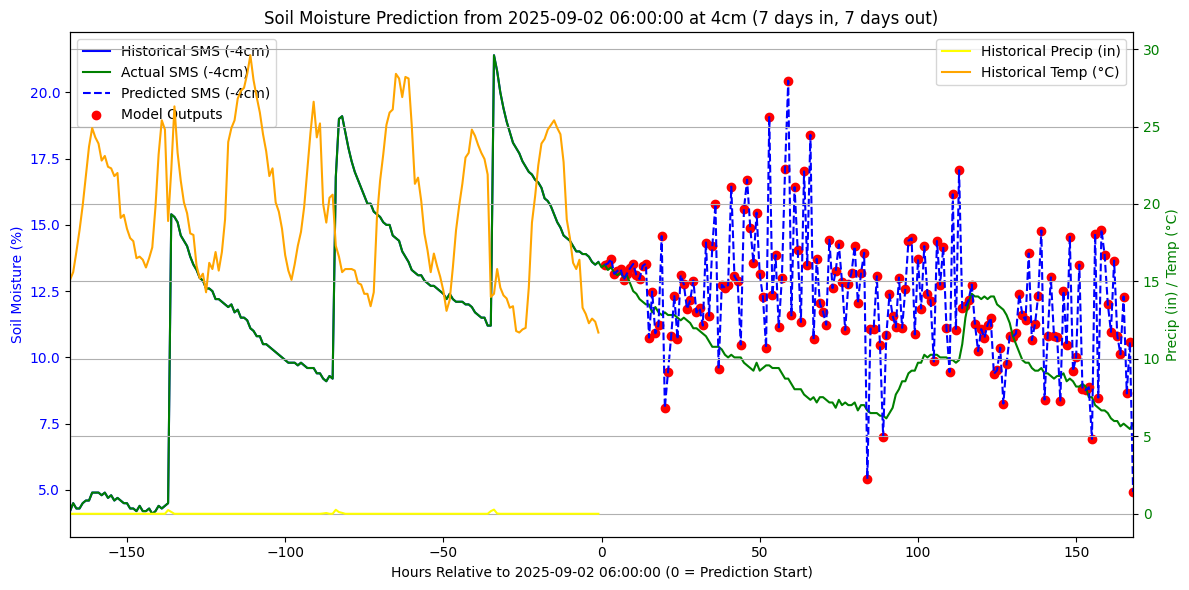

In [4]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_prediction_at_time(input_time, df, models, X_cols, horizons, target_col):
    """
    Generate a prediction graph for a user-specified time, showing 7 days before and 7 days after.
    
    Parameters:
    - input_time: pd.Timestamp or str (e.g., '2020-01-01 12:00') for the prediction start time
    - df: DataFrame containing the time series data
    - models: List of trained XGBoost models (one per horizon)
    - X_cols: List of feature column names
    - horizons: List of forecast horizons [1, 2, ..., 168]
    - target_col: Target column name (e.g., 'SMS.I-1:-4 (pct) (loam)')
    """
    # Convert input_time to Timestamp if it's a string
    if isinstance(input_time, str):
        input_time = pd.Timestamp(input_time)
    
    # Find the closest timestamp in df
    closest_time = df.index[df.index.get_indexer([input_time], method='nearest')[0]]
    print(f"Closest available time to {input_time}: {closest_time}")
    print(f"df index range: {df.index.min()} to {df.index.max()}")
    
    # Prepare input data for prediction
    input_X = df.loc[[closest_time], X_cols]
    
    # Predict for the next 7 days (hourly)
    preds = [models[i].predict(input_X)[0] for i in range(len(horizons))]
    
    # Interpolate to hourly (optional, since preds are already hourly)
    pred_hours = np.arange(1, 169, 1)  # 1 to 168 hours
    spline = CubicSpline(horizons, preds)
    hourly_preds = spline(pred_hours)
    
    # Get historical data (exactly 7 days before closest_time)
    past_hours = 168
    historical_df = df[[target_col, 'Precip (in)', 'TOBS.I-1 (degC)']].loc[
        closest_time - pd.Timedelta(hours=past_hours):closest_time - pd.Timedelta(hours=1)
    ]  # 168 hours, excluding end point
    historical_hours = np.arange(-past_hours, 0, 1)  # -168 to -1
    
    # Get actual data within the 7-day input and output window
    window_start = closest_time - pd.Timedelta(hours=past_hours)
    window_end = closest_time + pd.Timedelta(hours=168)
    actual_df = df[[target_col]].loc[window_start:window_end]
    print(f"Actual df index range: {actual_df.index.min() if not actual_df.empty else 'Empty'} to {actual_df.index.max() if not actual_df.empty else 'Empty'}")
    if not actual_df.empty:
        # Calculate actual_hours based on time difference in hours
        time_diffs = (actual_df.index - closest_time).total_seconds() / 3600  # Convert seconds to hours
        actual_hours = time_diffs.values
    else:
        actual_hours = np.array([])
        print("Warning: No actual data available within the 14-day window.")
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Left y-axis: Soil moisture (historical, predicted, actual)
    ax1.plot(historical_hours, historical_df[target_col], label='Historical SMS (-4cm)', color='blue')
    if not actual_df.empty:
        ax1.plot(actual_hours, actual_df[target_col], label='Actual SMS (-4cm)', color='green')
        print(f"Actual SMS range: {actual_hours[0]} to {actual_hours[-1]} hours")
    ax1.plot(pred_hours, hourly_preds, label='Predicted SMS (-4cm)', color='blue', linestyle='--')
    ax1.scatter(horizons, preds, color='red', label='Model Outputs')
    ax1.set_xlabel(f'Hours Relative to {closest_time} (0 = Prediction Start)')
    ax1.set_ylabel('Soil Moisture (%)', color='blue')
    ax1.set_xlim(-168, 168)  # Limit to 7 days before and 7 days after
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    
    # Right y-axis: Precipitation and Temperature (historical)
    ax2 = ax1.twinx()
    ax2.plot(historical_hours, historical_df['Precip (in)'], label='Historical Precip (in)', color='yellow')
    ax2.plot(historical_hours, historical_df['TOBS.I-1 (degC)'], label='Historical Temp (°C)', color='orange')
    ax2.set_ylabel('Precip (in) / Temp (°C)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    
    # Title and grid
    plt.title(f'Soil Moisture Prediction from {closest_time} at 4cm (7 days in, 7 days out)')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

# Example usage
plot_prediction_at_time('2025-09-02 06:00', df, models, X_cols, horizons, target_col)